In [1]:
import gensim
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

**TODO:** 

1. The valence of abortion, measured both in terms of the cosine similarities of these words to sets of postive and negative seed words, and also in terms of the valence of all 2500 words most closely linked to abortion for each party in each window.
    
**The basic questions**:
 
1. How has the level of discussion relating to abortion changed over time?
2. Do the parties discuss abortion using the same kinds of concepts, and has this changed over time?
3. Is abortion discussion valenced the same way by all of the parties, and has this changed over time?
        
That data are organized by party/year.

In [2]:
model = Word2Vec.load('../models/lipadmodel_3_1_rolling')
years_lib = set([year for year in range(1902,2019) if "abort_{}_Liberal".format(year) in model.wv.vocab ])
years_con = set([year for year in range(1902,2019) if "abort_{}_Conservative".format(year) in model.wv.vocab ])
years_ndp = set([year for year in range(1902,2019) if "abort_{}_NDP".format(year) in model.wv.vocab ])

print(len(years_lib), len(years_con), len(years_ndp))
comb = years_lib & years_con & years_ndp
comb = [year for year in comb if year > 1967 and year != 2018] # Because years before 1968 have very few mentions, discussion only takes off then.
print(comb)

72 70 60
[1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


### **Analyzing frequency of discussion around abortion**

In [4]:
count_freq = []
for year in comb:
    count_freq.append([model.wv.vocab["abort_{}_Liberal".format(year)].count,
                       model.wv.vocab["abort_{}_Conservative".format(year)].count,
                       model.wv.vocab["abort_{}_NDP".format(year)].count])

freq = np.array(count_freq)
fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=freq[:,0], name='Liberal'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=freq[:,1], name='Conservative'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=freq[:,2], name='NDP'))
fig.update_layout({'title':'Frequency of words',
                   'legend':{'orientation':'h',
                             'y':-0.15,
                             'yanchor':'top'}})
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Frequency')
fig.show()

### **Analyzing pair-wise similarity of the usage of abortion of NDP, Liberal, and Conservative party**

In [7]:
lib_con, ndp_con, ndp_lib = [], [], []
for year in comb:
    lib_con.append(model.wv.similarity("abort_{}_Liberal".format(year),"abort_{}_Conservative".format(year)))
    ndp_con.append(model.wv.similarity("abort_{}_NDP".format(year),"abort_{}_Conservative".format(year)))
    ndp_lib.append(model.wv.similarity("abort_{}_NDP".format(year),"abort_{}_Liberal".format(year)))

fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=lib_con, name='Liberal-Conservative'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=ndp_con, name='NDP-Conservative'))
fig.add_trace(go.Scatter(x=sorted(list(comb)), y=ndp_lib, name='NDP-Liberal'))
fig.update_layout({'title':'Pairwise Comparisons of NDP, Liberal, and Conservatives',
                   'legend':{'orientation':'h',
                             'y':-0.15,
                             'yanchor':'top'}})
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Similarity')
fig.show()

### **Analysis of similarity of the discussion around abortion to keywords** 

In [133]:
keywords = ('contraception', 'abstinence', 'human_rights', 'murder', 'infanticide', 'euthanasia')
lib, con, ndp = [], [], []
for word in keywords:
    history = [[],[],[]]
    for year in comb:
        history[0].append(model.wv.similarity("abort_{}_Liberal".format(year), word))
        history[1].append(model.wv.similarity("abort_{}_Conservative".format(year), word))
        history[2].append(model.wv.similarity("abort_{}_NDP".format(year), word))
    lib.append(history[0])
    con.append(history[1])
    ndp.append(history[2])

for i in range(len(keywords)):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sorted(list(comb)), y=lib[i], name='Liberal'))
    fig.add_trace(go.Scatter(x=sorted(list(comb)), y=con[i], name='Conservative'))
    fig.add_trace(go.Scatter(x=sorted(list(comb)), y=ndp[i], name='NDP'))
    fig.update_layout({'title':'Comparison to "{}" for Each Party'.format(keywords[i].capitalize()),
                       'legend':{'orientation':'h',
                                 'y':-0.15,
                                 'yanchor':'top'}})
    fig.update_xaxes(title='Year')
    fig.update_yaxes(title='Similarity')
    fig.show()

### Analysis of variance of similarity between pairs of words across models 

In [8]:
ref_model = Word2Vec.load('../models/lipadmodel_5_1')
pairs = []
for i in range(8000):
    pair = random.sample(ref_model.wv.vocab.keys(), 2)
    if not ('abort' in pair[0]) and not ('abort' in pair[1]):
        pairs.append(pair)

In [9]:
# pairs = [('man', 'woman'),('man', 'son'),('man', 'father'),('man', 'daughter'), 
#          ('husband', 'wife'), ('boy', 'girl'), ('peace','love'), 
#          ('freedom', 'religion'), ('right', 'charter'), ('conservative', 'ndp'),
#          ('conservative', 'liberal'), ('liberal', 'ndp'), ('terrorism', 'afghanistan'),]
num_groups = 6
set_all = set([word for pair in pairs for word in pair])
counts = {word:ref_model.wv.vocab[word].count for word in set_all}

In [10]:
similarity = []
for group in tqdm(range(1, num_groups+1)):
    model = Word2Vec.load('../models/lipadmodel_{}_1'.format(group))
    for pair in pairs:
        similarity.append(model.wv.similarity(pair[0], pair[1]))

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Mean and std. dev of pair similarity across 6 different models


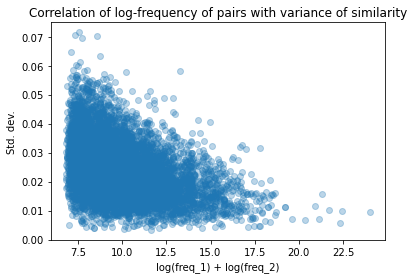

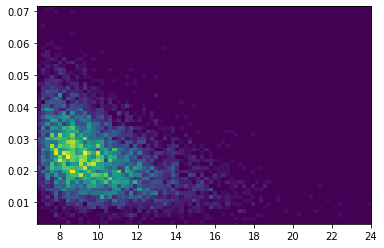

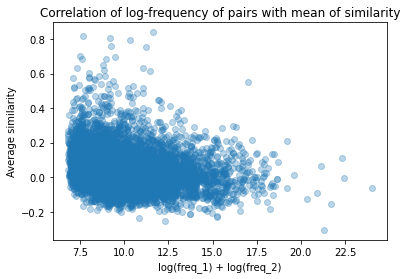

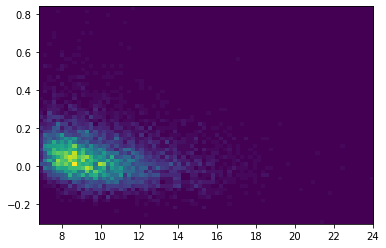

In [11]:
sims = np.array(similarity).reshape((num_groups,len(pairs)))
m = np.mean(sims, axis=0)
s = np.std(sims, axis=0)
counts_np = np.array([np.log(counts[pair[0]] * counts[pair[1]]) for pair in pairs])

print(f"Mean and std. dev of pair similarity across {num_groups} different models")
# for i in range(len(pairs)):
#     print(m[i], s[i], pairs[i]) 
    
plt.scatter(counts_np, s, alpha=0.3)
plt.title('Correlation of log-frequency of pairs with variance of similarity')
plt.xlabel('log(freq_1) + log(freq_2)')
plt.ylabel('Std. dev.')
plt.show()

heatmap, xedges, yedges = np.histogram2d(counts_np, s, bins=(80,60))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, aspect='auto', origin='lower')
plt.show()

plt.scatter(counts_np, m, alpha=0.3)
plt.title('Correlation of log-frequency of pairs with mean of similarity')
plt.xlabel('log(freq_1) + log(freq_2)')
plt.ylabel('Average similarity')
plt.show()

heatmap, xedges, yedges = np.histogram2d(counts_np, m, bins=(80,60))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, aspect='auto', origin='lower')
plt.show()


### Clustering and Dimensionality Reduction 

In [3]:
model = Word2Vec.load('../models/lipadmodel_3_1_rolling')

In [4]:
ndp_abort_words = ['abort_{}_NDP'.format(year) for year in years_ndp if year>1960]
con_abort_words = ['abort_{}_Conservative'.format(year) for year in years_con if year>1960]
lib_abort_words = ['abort_{}_Liberal'.format(year) for year in years_lib if year>1960]

# l = [word[0] for word in model.wv.most_similar_cosmul(ndp_abort_words, topn=150) if ("abort_" not in word[0])]
# for i in l:
#     print(i, model.wv.similarity(i, 'abort_1990_NDP'))

In [5]:
ndp_vectors = np.concatenate([np.expand_dims(model.wv.get_vector(word),axis=1) for word in ndp_abort_words], axis=1)
lib_vectors = np.concatenate([np.expand_dims(model.wv.get_vector(word),axis=1) for word in lib_abort_words], axis=1)
con_vectors = np.concatenate([np.expand_dims(model.wv.get_vector(word),axis=1) for word in con_abort_words], axis=1)

total = np.concatenate([ndp_vectors, lib_vectors, con_vectors], axis=1).T
party = ['ndp'] * ndp_vectors.shape[1] + ['lib'] * lib_vectors.shape[1] + ['con'] * con_vectors.shape[1]
year = [int(word.split('_')[1]) for word in ndp_abort_words] + \
       [int(word.split('_')[1]) for word in lib_abort_words] + \
       [int(word.split('_')[1]) for word in con_abort_words]

In [6]:
features = ["dim_"+str(i) for i in range(total.shape[1])]
df = pd.DataFrame(total.copy(), columns=features)
df['party'] = party
df['year'] = year
df['time'] = [(int(y/20)*20) for y in year]

In [9]:
%matplotlib inline

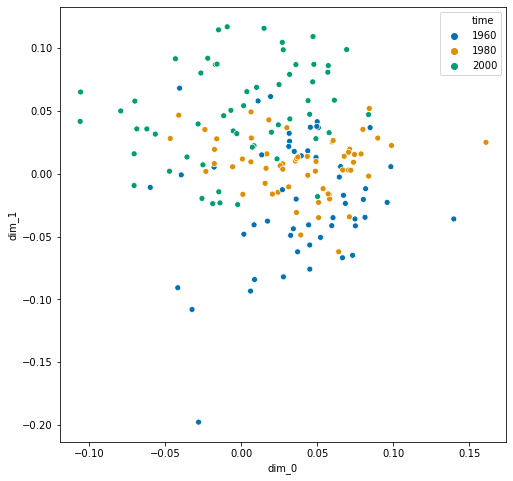

In [7]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
sns.scatterplot(x="dim_0", y="dim_1", hue='time',palette='colorblind', data=df)
plt.show()

### 2-D PCA

In [15]:
%matplotlib notebook

[0.12620889 0.07548839 0.05067755]


<IPython.core.display.Javascript object>


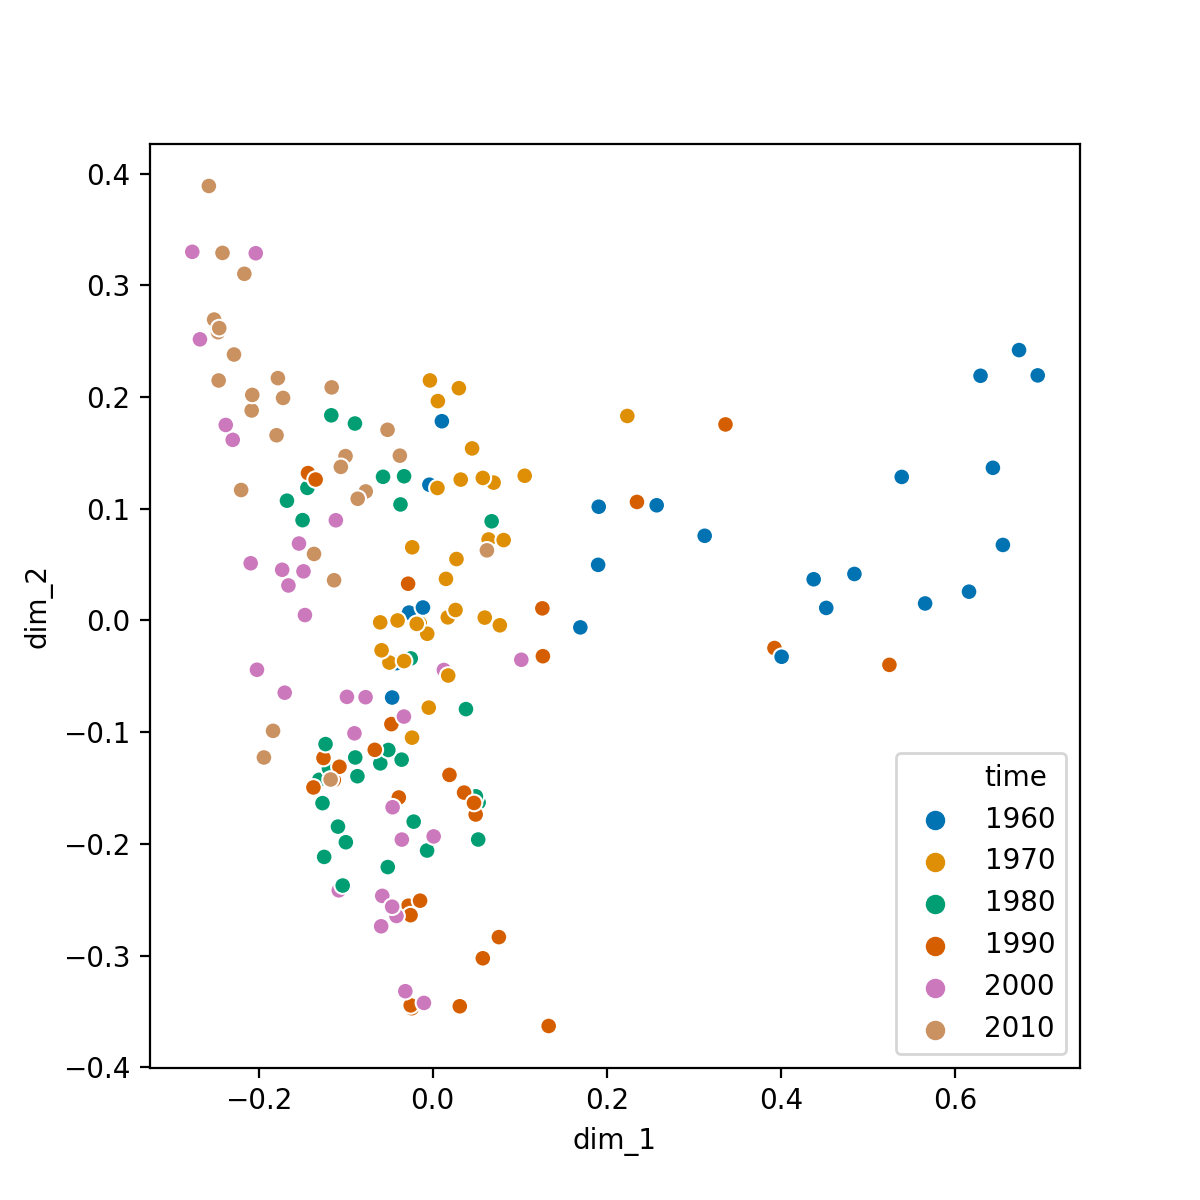

<IPython.core.display.Javascript object>


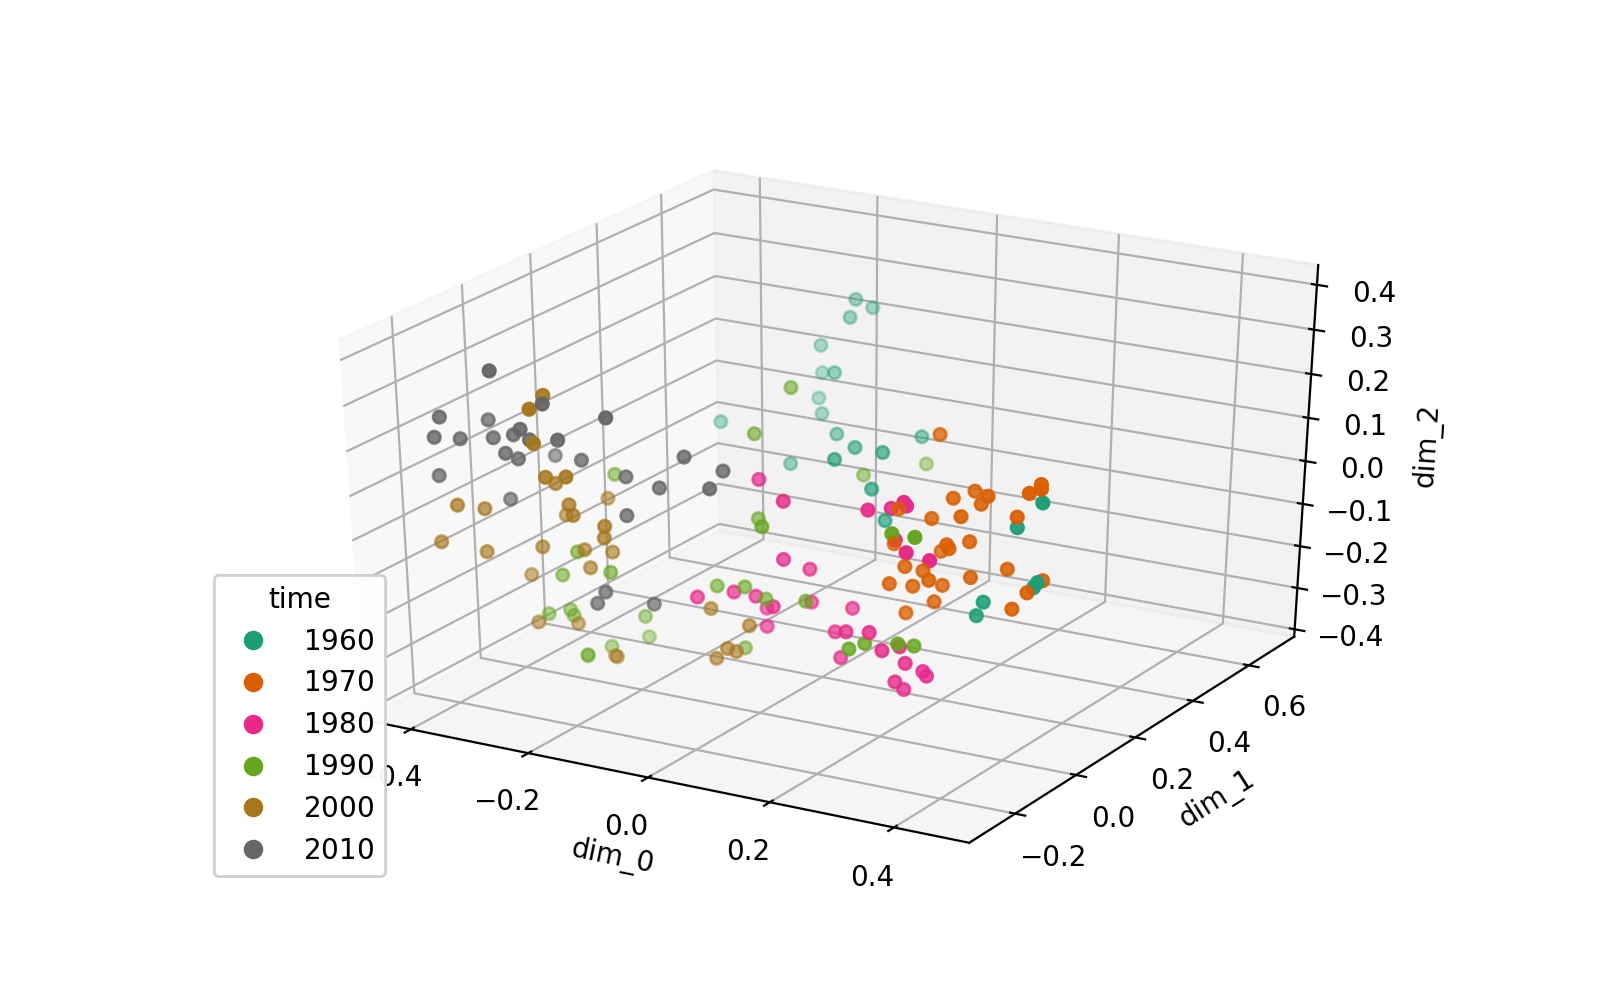

In [26]:
df = pd.DataFrame(total.copy(), columns=features)
df['party'] = party
df['year'] = year
df['time'] = [str(int(y/10)*10) for y in year]

pca = PCA(n_components=3)
transformed = pca.fit_transform(df[features].values)
print(pca.explained_variance_ratio_)
df['dim_0'] = transformed[:, 0].copy()
df['dim_1'] = transformed[:, 1].copy()
df['dim_2'] = transformed[:, 2].copy()

fig = plt.gcf()
fig.set_size_inches(6, 6)
s = sns.scatterplot(x="dim_1", y="dim_2", hue="time",palette="colorblind",data=df)
plt.show() 
# plt.close()

df['time'] = [(int(y/10)*10) for y in year]
ax = plt.figure(figsize=(8,5)).gca(projection='3d')
scatter = ax.scatter(
    xs=df["dim_0"], 
    ys=df["dim_1"], 
    zs=df["dim_2"], 
    c=df["time"], 
    cmap='Dark2'
)
ax.set_xlabel('dim_0')
ax.set_ylabel('dim_1')
ax.set_zlabel('dim_2')
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="time")
ax.add_artist(legend)
plt.show()

In [10]:
most_freq = sorted(model.wv.vocab, key = lambda v: model.wv.vocab[v].count, reverse=True)[:100000]
most_freq = [w for w in most_freq if 'abort' not in w ]
print(len(most_freq))
freq_vectors = np.concatenate([np.expand_dims(model.wv.get_vector(word),axis=1) for word in most_freq], axis=1).T
features = ["dim_"+str(i) for i in range(total.shape[1])]
df_freq = pd.DataFrame(freq_vectors.copy(), columns=features)
df_freq['word'] = most_freq

99851


<IPython.core.display.Javascript object>


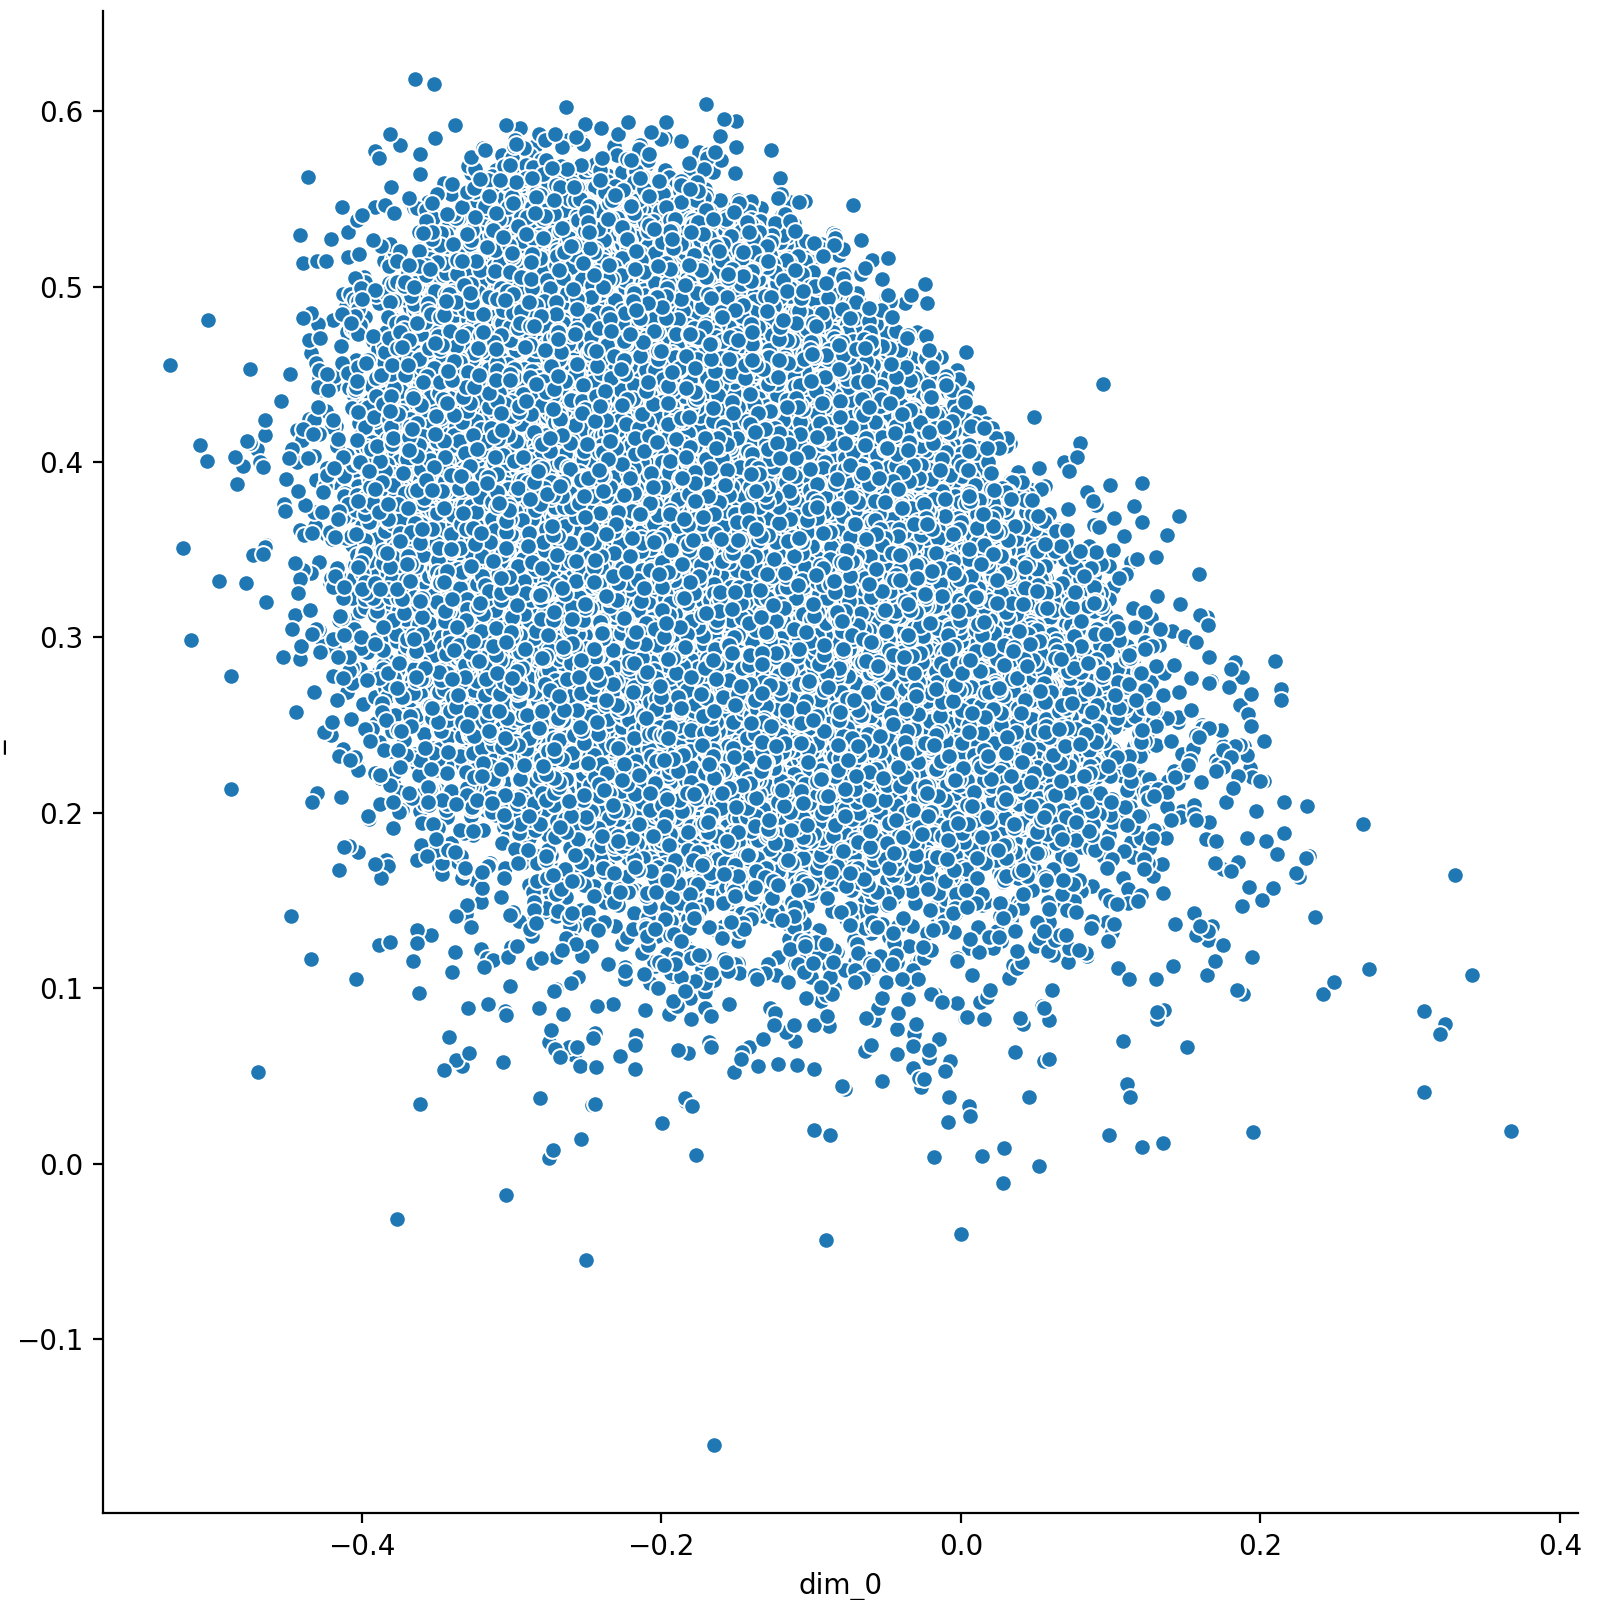

In [22]:
transformed_freq = pca.transform(df_freq[features].values)
df_freq['dim_0'] = transformed_freq[:, 0].copy()
df_freq['dim_1'] = transformed_freq[:, 1].copy()
df_freq['dim_2'] = transformed_freq[:, 2].copy()

sns.pairplot(x_vars=["dim_0"], y_vars=["dim_1"], data=df_freq, height=8)

In [12]:
def func(row, left,  right):
    return np.linalg.norm(np.array([left, right]) - np.array([row.dim_0, row.dim_1]))

df_freq['corner1'] = df.apply(lambda g: func(g,-0.2,0.4),axis=1)
df_freq['corner2'] = df.apply(lambda g: func(g,0.8,0.4),axis=1)
df_freq['corner3'] = df.apply(lambda g: func(g,-0.2,-0.4),axis=1)
df_freq['corner4'] = df.apply(lambda g: func(g,0.8,-0.4),axis=1)

In [14]:
# Many things change when the years are kept to > 1960
df_dim_0 = df_freq.sort_values('dim_0') # negative is closer to modern definitions of abortion and related words, positive is mumbo-jumbo words
print(color.BOLD + "\nDimension # 0 " + color.END)
print(color.BOLD + "Negative: " + color.END + str(df_dim_0['word'][:20].values))
print(color.BOLD + "Positive: " + color.END + str(df_dim_0['word'][-20:].values))

df_dim_1 = df_freq.sort_values('dim_1') # negative is clearly related to criminality, positive is womens/lgbtq rights
print(color.BOLD + "\nDimension # 1" + color.END)
print(color.BOLD + "Negative: " + color.END + str(df_dim_1['word'][:20].values))
print(color.BOLD + "Positive: " + color.END + str(df_dim_1['word'][-20:].values))

df_dim_2 = df_freq.sort_values('dim_2') # negative points to legal and political factors (law, wars, opposition), positive points to biological terms 
print(color.BOLD + "\nDimension # 2" + color.END)
print(color.BOLD + "Negative: " + color.END + str(df_dim_2['word'][:20].values))
print(color.BOLD + "Positive: " + color.END + str(df_dim_2['word'][-20:].values))

# df_c_1 = df_freq.sort_values('corner1')
# print(df_dim_0['word'][:10])

# df_c_2 = df_freq.sort_values('corner2')
# print(df_dim_1['word'][:10])

# df_c_3 = df_freq.sort_values('corner3')
# print(df_dim_0['word'][:10])

# df_c_4 = df_freq.sort_values('corner4')
# print(df_dim_1['word'][:10])


Dimension # 0 
Negative: ['hardwon' 'ardent_defender' 'invested_heavily' 'advancing_gender'
 'staunch_defender' 'empowerment_women' 'reiterated_commitment'
 'invested_significantly' 'investing_heavily' 'aimed_promoting'
 'hardearned' 'workplace_skills' 'adjournment_follows' 'agri'
 'document_entitled' 'championing' 'remains_focused' 'jealously_guard'
 'strong_advocate' 'champion']
Positive: ['heroin_addicts' 'dr_morgentaler' 'death_penalty' 'addicts' 'divorces'
 'legalization' 'medical_practitioners' 'homosexuality' 'impaired_driving'
 'capital_punishment' 'assisted_dying' 'decriminalization' 'wiretapping'
 'termination_pregnancy' 'euthanasia' 'assisted_suicide' 'use_heroin'
 'therapeutic' 'physicianassisted_suicide' 'Créditiste']

Dimension # 1
Negative: ['Québécois' 'maternal_health' 'womens_equality' 'pregnant_woman'
 'pregnant_women' 'women_girls' 'religious_minorities'
 'traditional_marriage' 'gays_lesbians' 'pregnancy' 'contraception'
 'sex_marriage' 'female_genital' 'unwanted_p

### T-SNE 

In [78]:
%matplotlib inline

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 202 samples in 0.000s...
[t-SNE] Computed neighbors for 202 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 202 / 202
[t-SNE] Mean sigma: 0.392744
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.053452
[t-SNE] KL divergence after 300 iterations: 0.580989


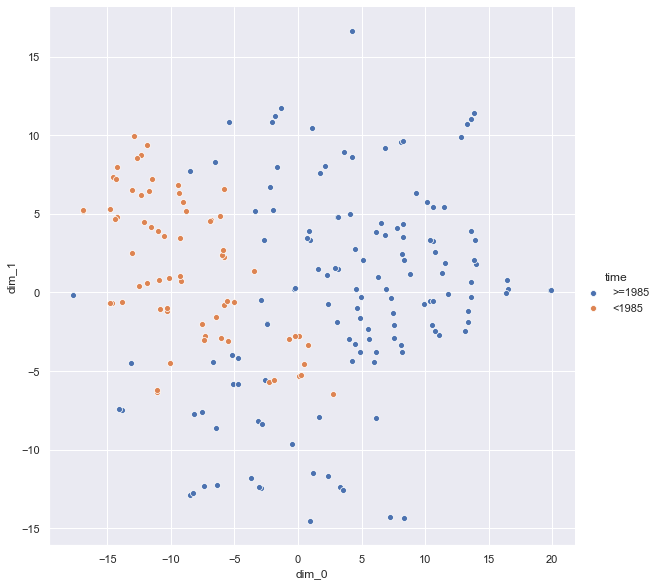

In [79]:
df = pd.DataFrame(total.copy(), columns=features)
df['party'] = party
df['year'] = year
df['time'] = ['>=1985' if y<=1995 else '<1985' for y in year]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
transformed = tsne.fit_transform(df[features].values)

df['dim_0'] = transformed[:, 0].copy()
df['dim_1'] = transformed[:, 1].copy()
sns.pairplot(x_vars=["dim_0"], y_vars=["dim_1"], data=df, hue="time", height=8)
plt.show() 
plt.close()